In [38]:
!pip install kaggle
from google.colab import files
files.upload()

{}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Jan 27 02:57 kaggle.json


In [3]:
!kaggle competitions download -c sejongai-challenge-pretest-2

  0% 0.00/56.3k [00:00<?, ?B/s]
100% 56.3k/56.3k [00:00<00:00, 51.6MB/s]
  0% 0.00/17.1k [00:00<?, ?B/s]
100% 17.1k/17.1k [00:00<00:00, 14.7MB/s]
  0% 0.00/3.09k [00:00<?, ?B/s]
100% 3.09k/3.09k [00:00<00:00, 3.13MB/s]


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import random
import os

seed=0
np.random.seed(777)
tf.random.set_seed(777)

pd_train = pd.read_csv('2020.AI.bike-train.csv')
pd_test = pd.read_csv('2020.AI.bike-test.csv')

pd_train

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
995,1647,14,20.4,0.0,3.6,12.0,2000.0,0.047,23.0,13.0,108.0
996,1649,15,18.5,0.0,4.1,24.0,849.0,0.064,92.0,83.0,78.0
997,1650,4,16.1,0.0,0.6,60.0,2000.0,0.028,39.0,28.0,27.0
998,1652,16,17.7,0.0,2.3,32.0,1949.0,0.037,64.0,22.0,118.0


### 데이터 시각화

#### 히트맵으로 상관관계 분석

     hour  hour_bef_temperature  ...  hour_bef_pm2.5  count
0      20                  16.3  ...            33.0   49.0
1      13                  20.1  ...            40.0  159.0
2       6                  13.9  ...            19.0   26.0
3      23                   8.1  ...            64.0   57.0
4      18                  29.5  ...            11.0  431.0
..    ...                   ...  ...             ...    ...
995    14                  20.4  ...            13.0  108.0
996    15                  18.5  ...            83.0   78.0
997     4                  16.1  ...            28.0   27.0
998    16                  17.7  ...            22.0  118.0
999     6                  10.7  ...            28.0    5.0

[1000 rows x 10 columns]


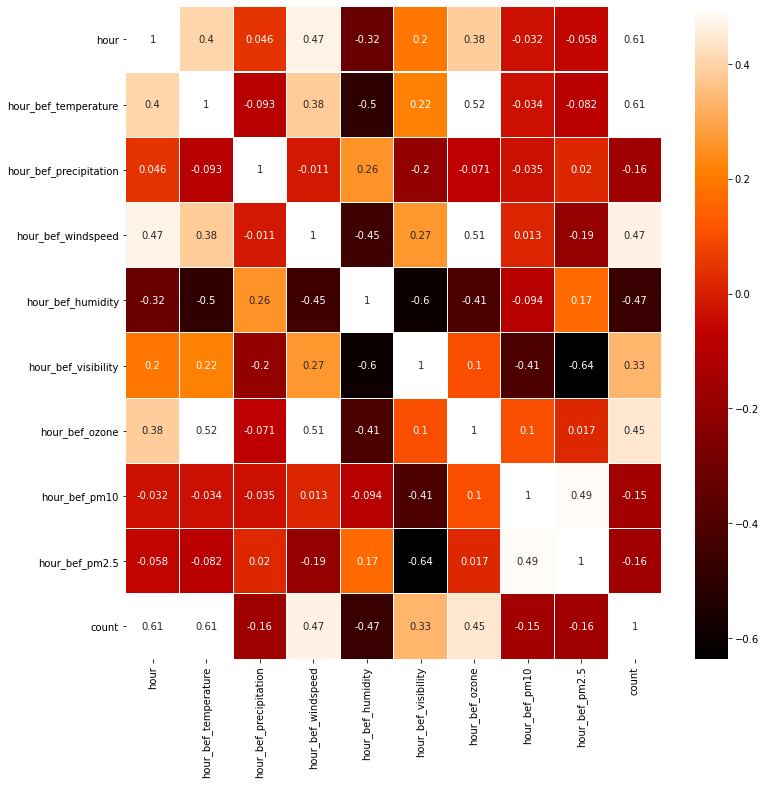

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

map=pd_train.iloc[:,1:]

print(map)

plt.figure(figsize=(12,12))
sns.heatmap(map.corr(), linewidths=0.1, vmax=0.5, cmap=plt.cm.gist_heat, linecolor='white', annot=True)
plt.show()

우리는 count가 중요하니까 count와 연관된 항목을 보면  
시간,온도,풍속이 가장 연관이 높은 것을 알 수 있다.

#### 시간과 사용자 수

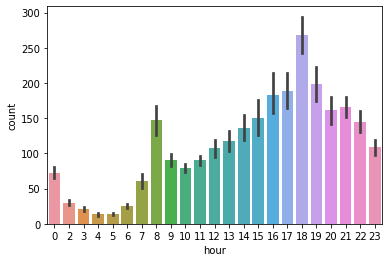

In [6]:
sns.barplot(x="hour", y="count", data=pd_train);

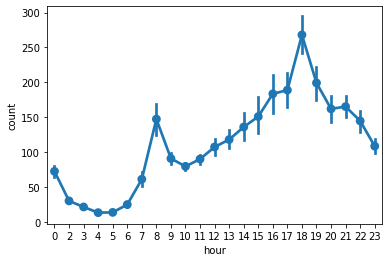

In [7]:
sns.pointplot(data=pd_train, x="hour", y="count")

* 16시에서 19시 가장 많이 이용
* 주목할 점은 8시와 18시 사용자수 급증 -> 출퇴근 시 많이 이용하는것으로 예측

#### 온도와 사용자 수

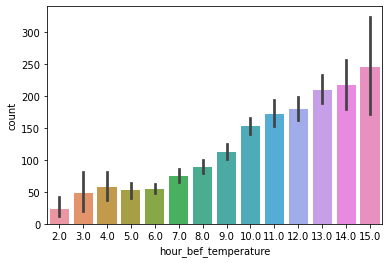

In [8]:
def make_bins(d, col, factor=2):
    rounding = lambda x: np.around(x / factor)
    d[col] = d[col].apply(rounding)
    return d

t = make_bins(pd_train.copy(True), 'hour_bef_temperature', 2)
sns.barplot(x="hour_bef_temperature", y="count", data=t);

* 대체로 온도가 증가함에 따라 사용자수 증가 => 따뜻한 날씨에 많이 이용하는것으로 생각

#### 풍속과 사용자 수

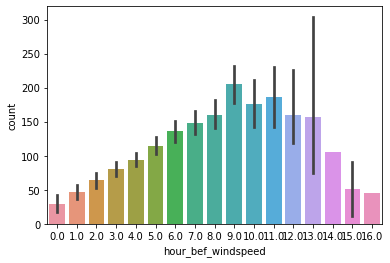

In [9]:
t = make_bins(pd_train.copy(True), 'hour_bef_windspeed', 0.5)
sns.barplot(x="hour_bef_windspeed", y="count", data=t);

* 풍속이 44 에서 65 정도인 범위에서 사용자가 많고 풍속이 137 이상인 범위에서는 사용자 적음
* 해석: 사용자가 많이 사용하는 온도와 시간대의 풍속이 44~65 범위여서 저렇게 나오는것 같음 

#### hour_bef_precipitation 과 사용자수

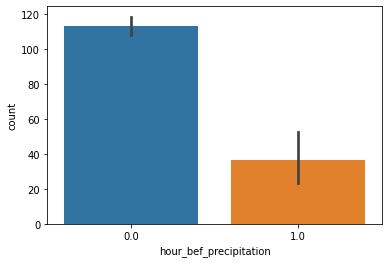

In [10]:
sns.barplot(x="hour_bef_precipitation", y="count", data=pd_train);

#### 습도와 사용자 수

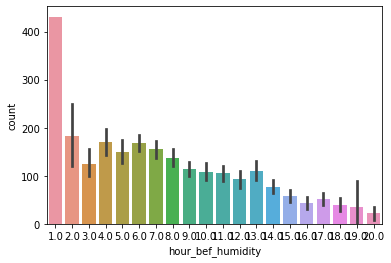

In [11]:
t = make_bins(pd_train.copy(True), 'hour_bef_humidity', 5)
sns.barplot(x="hour_bef_humidity", y="count", data=t);

#### hour_bef_visibility과 사용자 수

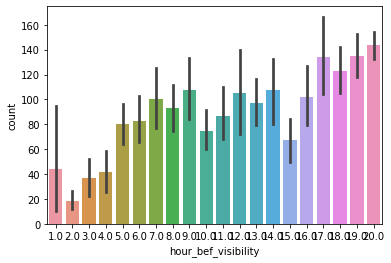

In [12]:
t = make_bins(pd_train.copy(True), 'hour_bef_visibility', 100)
sns.barplot(x="hour_bef_visibility", y="count", data=t);

#### hour_bef_ozone과 사용자 수

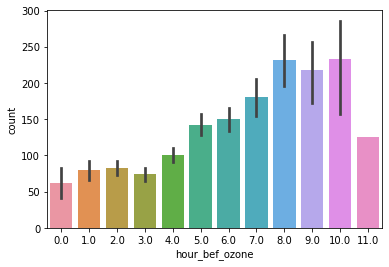

In [13]:
t = make_bins(pd_train.copy(True), 'hour_bef_ozone', 0.01)
sns.barplot(x="hour_bef_ozone", y="count", data=t);

#### hour_bef_pm10과 사용자 수

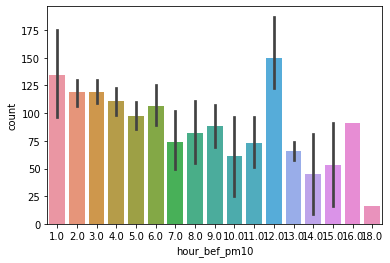

In [14]:
t = make_bins(pd_train.copy(True), 'hour_bef_pm10', 15)
sns.barplot(x="hour_bef_pm10", y="count", data=t);

#### hour_bef_pm2과 사용자 *수*

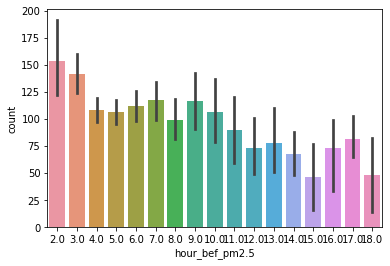

In [15]:
t = make_bins(pd_train.copy(True), 'hour_bef_pm2.5', 5)
sns.barplot(x="hour_bef_pm2.5", y="count", data=t);

### 데이터 전처리

In [16]:
x_train = pd_train.iloc[1:,1:-1]
y_train = pd_train.iloc[1:,-1]
x_train

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
1,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0
2,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0
3,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0
4,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0
5,2,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0
...,...,...,...,...,...,...,...,...,...
995,14,20.4,0.0,3.6,12.0,2000.0,0.047,23.0,13.0
996,15,18.5,0.0,4.1,24.0,849.0,0.064,92.0,83.0
997,4,16.1,0.0,0.6,60.0,2000.0,0.028,39.0,28.0
998,16,17.7,0.0,2.3,32.0,1949.0,0.037,64.0,22.0


MinMaxScaler 사용 -> x_train 0~1 사이 값으로 변환

Scaler에 대한 설명 : https://mkjjo.github.io/python/2019/01/10/scaler.html

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_train

array([[0.56521739, 0.63197026, 0.        , ..., 0.37864078, 0.23735409,
        0.38271605],
       [0.26086957, 0.40148699, 0.        , ..., 0.29126214, 0.07782101,
        0.12345679],
       [1.        , 0.18587361, 0.        , ..., 0.3592233 , 0.24513619,
        0.67901235],
       ...,
       [0.17391304, 0.48327138, 0.        , ..., 0.24271845, 0.10505837,
        0.2345679 ],
       [0.69565217, 0.54275093, 0.        , ..., 0.33009709, 0.20233463,
        0.16049383],
       [0.26086957, 0.28252788, 0.        , ..., 0.30097087, 0.07782101,
        0.2345679 ]])

In [18]:
x_train.shape

(999, 9)

In [19]:
y_train = np.array(y_train)
y_train

array([159.,  26.,  57., 431.,  39.,  23., 146.,  39.,  83.,   6.,  42.,
        59.,  60.,   5., 217.,  64.,  15.,  58., 209., 122.,  87.,  30.,
        34.,  29.,  18., 106.,  10.,  81., 258., 150., 214., 115., 155.,
       138., 221.,  16., 218., 201., 110.,  30., 268., 268.,  93.,  12.,
       130.,  89.,  88.,  23., 187.,  95.,  19.,  60., 172.,   3.,  36.,
       190., 139., 264.,  23., 137., 120., 348.,  38.,  21., 121.,  15.,
         3., 101.,  41., 117.,  12., 124.,  86., 104.,  76., 222., 106.,
       100., 130., 106.,  30., 196., 191.,  82.,  41.,  10.,  99., 183.,
       252., 108., 104., 204., 116.,   3., 102., 112., 191.,   8.,   8.,
       369., 107., 164.,   5.,  65., 185., 125., 291., 250.,  37.,  97.,
       249., 145.,  16., 132., 194.,  69.,  20., 304.,  97.,   6.,  12.,
        97.,  86.,  58.,   9., 118.,  60., 148.,  50.,  11., 115.,  80.,
       122., 247., 121.,  85., 104.,  75.,  30., 293.,  92.,  17., 104.,
        12., 119., 111., 278.,  10., 305., 115.,  7

In [20]:
y_train.shape

(999,)

#### 모델 설계 및 학습

Dropout에 대한 설명 : https://ardino-lab.com/drop-out%EB%93%9C%EB%A1%AD%EC%95%84%EC%9B%83%EC%9D%B4%EB%9E%80-%EB%93%9C%EB%A1%AD-%EC%95%84%EC%9B%83-%EC%8B%A0%EA%B2%BD%EB%A7%9D-%EA%B5%AC%EC%A1%B0/

In [21]:
from keras.layers import Flatten, Dropout, BatchNormalization
model=Sequential()

model.add(Dense(128,input_shape=(9,),activation='relu'))
model.add(Dropout(0.25))       

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(24, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1))

#ad = optimizers.Adam(lr = 0.001)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

In [22]:
# MODEL_DIR = './model5/'
# if not os.path.exists(MODEL_DIR):
#   os.mkdir(MODEL_DIR)

# modelpath="./model5/{epoch:02d}-{val_loss:.4f}.hdf5"

k겹 검증 하려 했으나 맞게 설계했는지 모르겠고 제출결과 캐글 성과 더 안좋아짐 ;;

In [23]:
'''from sklearn.model_selection import StratifiedKFold


n_fold =5 # 5겹 교차
skf = StratifiedKFold(n_splits = n_fold ,shuffle=True, random_state = 0)


# 모델설정
from keras.layers import Flatten, Dropout, BatchNormalization
model=Sequential()
#model=Sequential()
model.add(Dense(128,input_shape=(9,),activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# 모델설정 및 실행
for train,test in skf.split(x_train,y_train):
  
  early_stopping_callback = EarlyStopping(monitor='mse', patience=200)
  
  hist=model.fit(x_train[train],y_train[train],epochs=300, batch_size=25,callbacks=[early_stopping_callback])
  # 여기서 n번째 count 값을 저장해놓고 마지막에 평균을 구해야 될것 같은데 맞는지 모르겠다.
  
'''
 


"from sklearn.model_selection import StratifiedKFold\n\n\nn_fold =5 # 5겹 교차\nskf = StratifiedKFold(n_splits = n_fold ,shuffle=True, random_state = 0)\n\n\n# 모델설정\nfrom keras.layers import Flatten, Dropout, BatchNormalization\nmodel=Sequential()\n#model=Sequential()\nmodel.add(Dense(128,input_shape=(9,),activation='relu'))\n#model.add(BatchNormalization())\nmodel.add(Dropout(0.3))\nmodel.add(Dense(64, activation='relu'))\n#model.add(BatchNormalization())\nmodel.add(Dropout(0.3))\nmodel.add(Dense(24, activation='relu'))\n#model.add(BatchNormalization())\nmodel.add(Dropout(0.3))\nmodel.add(Dense(1))\n\nmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])\n\n# 모델설정 및 실행\nfor train,test in skf.split(x_train,y_train):\n  \n  early_stopping_callback = EarlyStopping(monitor='mse', patience=200)\n  \n  hist=model.fit(x_train[train],y_train[train],epochs=300, batch_size=25,callbacks=[early_stopping_callback])\n  # 여기서 n번째 count 값을 저장해놓고 마지막에 평균을 구해야 될것 같은데 맞는지 모르겠다.\n  \n"

In [24]:
# checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=150)

In [25]:
hist=model.fit(x_train,y_train,epochs=5000, batch_size=25, validation_split=0.25, callbacks=[early_stopping_callback])
#hist=model.fit(x_train,y_train,epochs=5000, batch_size=25, validation_split=0.2, callbacks=[early_stopping_callback, checkpointer])
#hist=model.fit(x_train,y_train,epochs=400, batch_size=25, validation_split=0.25)

Epoch 1/5000
30/30 [==============================] - 2s 14ms/step - loss: 20228.8579 - mse: 20228.8579 - val_loss: 16999.7305 - val_mse: 16999.7305
Epoch 2/5000
30/30 [==============================] - 0s 3ms/step - loss: 18504.3430 - mse: 18504.3431 - val_loss: 11543.3711 - val_mse: 11543.3711
Epoch 3/5000
30/30 [==============================] - 0s 3ms/step - loss: 10771.4237 - mse: 10771.4237 - val_loss: 4738.6914 - val_mse: 4738.6914
Epoch 4/5000
30/30 [==============================] - 0s 3ms/step - loss: 5663.4754 - mse: 5663.4754 - val_loss: 4335.4395 - val_mse: 4335.4395
Epoch 5/5000
30/30 [==============================] - 0s 3ms/step - loss: 5629.9854 - mse: 5629.9854 - val_loss: 3935.2161 - val_mse: 3935.2161
Epoch 6/5000
30/30 [==============================] - 0s 3ms/step - loss: 4739.1347 - mse: 4739.1348 - val_loss: 3607.3816 - val_mse: 3607.3816
Epoch 7/5000
30/30 [==============================] - 0s 3ms/step - loss: 5020.2051 - mse: 5020.2051 - val_loss: 3258.4854 - 

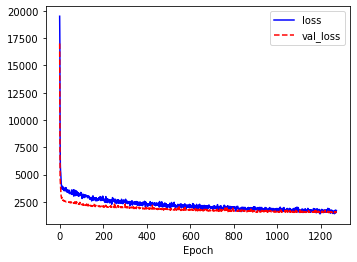

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

#### 테스트 셋 전처리

In [27]:
pd_test

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,1655,4,14.6,0.0,0.6,49.0,2000.0,0.014,41.0,27.0
1,1657,20,21.8,0.0,4.4,40.0,2000.0,0.048,35.0,19.0
2,1660,22,18.3,0.0,1.0,37.0,970.0,0.032,169.0,38.0
3,1662,7,13.2,0.0,0.6,85.0,431.0,0.023,50.0,39.0
4,1663,8,8.9,0.0,0.9,77.0,613.0,0.005,82.0,40.0
...,...,...,...,...,...,...,...,...,...,...
322,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0
323,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0
324,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0
325,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0


In [28]:
test_data = pd_test.iloc[:,1:]
test_data

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,4,14.6,0.0,0.6,49.0,2000.0,0.014,41.0,27.0
1,20,21.8,0.0,4.4,40.0,2000.0,0.048,35.0,19.0
2,22,18.3,0.0,1.0,37.0,970.0,0.032,169.0,38.0
3,7,13.2,0.0,0.6,85.0,431.0,0.023,50.0,39.0
4,8,8.9,0.0,0.9,77.0,613.0,0.005,82.0,40.0
...,...,...,...,...,...,...,...,...,...
322,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0
323,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0
324,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0
325,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0


In [29]:
# model=load_model("./model5/362-1255.0397.hdf5")

Test Data를 처리할때 쓴 Scaler를 그대로 가져와 사용

In [30]:
test_data = scaler.transform(test_data)
test_data

array([[0.17391304, 0.42750929, 0.        , ..., 0.10679612, 0.11284047,
        0.22222222],
       [0.86956522, 0.69516729, 0.        , ..., 0.4368932 , 0.08949416,
        0.12345679],
       [0.95652174, 0.56505576, 0.        , ..., 0.2815534 , 0.61089494,
        0.35802469],
       ...,
       [0.2173913 , 0.56505576, 0.        , ..., 0.05825243, 0.07003891,
        0.14814815],
       [0.91304348, 0.65427509, 0.        , ..., 0.76699029, 0.22957198,
        0.33333333],
       [0.73913043, 0.66914498, 0.        , ..., 0.41747573, 0.10116732,
        0.09876543]])

예측값 구하기

In [31]:
y_test = model.predict(test_data)
y_test

array([[ 21.160389 ],
       [214.7233   ],
       [113.87822  ],
       [ 24.164516 ],
       [ 59.62845  ],
       [302.6757   ],
       [ 36.355263 ],
       [182.29344  ],
       [126.792015 ],
       [104.65922  ],
       [  8.969386 ],
       [168.00017  ],
       [ 22.761806 ],
       [ 20.191538 ],
       [154.5132   ],
       [ 93.26968  ],
       [ 96.8422   ],
       [261.8746   ],
       [106.16812  ],
       [ 84.805885 ],
       [221.63492  ],
       [131.26654  ],
       [ 33.52379  ],
       [104.84469  ],
       [213.15298  ],
       [ 38.709503 ],
       [180.73186  ],
       [145.67473  ],
       [179.74562  ],
       [121.40151  ],
       [ 12.941532 ],
       [ 42.387962 ],
       [ 81.016884 ],
       [151.99991  ],
       [109.54897  ],
       [210.59631  ],
       [110.85499  ],
       [170.30185  ],
       [ 52.148308 ],
       [141.07222  ],
       [ 45.835907 ],
       [ 98.27418  ],
       [120.59268  ],
       [122.44993  ],
       [145.6575   ],
       [18

In [32]:
len(y_test)

327

In [33]:
pd_submit = pd.read_csv('2020.AI.bike-submission.csv')
print(pd_submit)

      id  count
0    0.0    0.0
1    0.0    1.0
2    0.0    2.0
3    0.0    3.0
4    0.0    4.0
..   ...    ...
322  0.0  322.0
323  0.0  323.0
324  0.0  324.0
325  0.0  325.0
326  0.0  326.0

[327 rows x 2 columns]


#### 예측값 전처리

In [34]:
for i in range(len(pd_submit)):
  pd_submit['id'][i] = int(i)
  pd_submit['count'][i] = y_test[i]
  pd_submit['id']= pd_submit['id'].astype(int)
  pd_submit['count']= pd_submit['count']
pd_submit


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,count
0,0,21.160389
1,1,214.723297
2,2,113.878220
3,3,24.164516
4,4,59.628448
...,...,...
322,322,26.258486
323,323,27.444098
324,324,30.876600
325,325,191.971634


csv파일로 저장

In [35]:
pd_submit.to_csv("result_bike3.csv", index=False,header=True)

In [36]:
!kaggle competitions submit -c sejongai-challenge-pretest-2 -f result_bike3.csv -m "Message"

100% 7.03k/7.03k [00:00<00:00, 17.4kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 26-28: ordinal not in range(256)
